# **Finding Lane Lines on the Road** 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


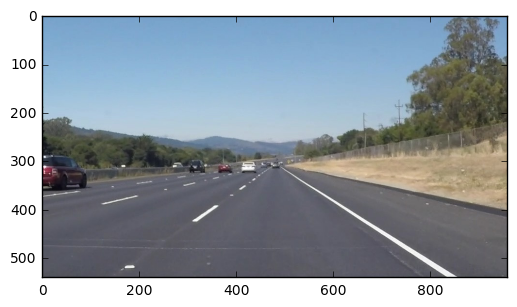

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, a=0.7, b=1., g=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, a, img, b, g)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [13]:
def x_val_point(line, y):
    '''returns the coordinate of the line for a given y value'''
    m = slope(line)
    x1,y1,x2,y2 = line[0]
    return [int(1.0*(y-y1)/m +x1+.5), y]

def length(line):
    '''returns the length of the line'''
    x1,y1,x2,y2 = line[0]
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def slope(line):
    '''returns the slope'''
    x1,y1,x2,y2 = line[0]
    if x1==x2:
        return np.inf
    return 1.0*(y2-y1)/(x2-x1)

def wavg(v,w, rounded=True):
    '''generic weighted average'''
    x= np.dot(v,w)/np.sum(w)
    if rounded:
        return int(x+.5)
    else:
        return x

def filter_lines_by_slope(lines,xs,low=.5):
    '''takes a line set and returns only lines that sort of vertical and pointed in the right direction
       for where they are on the screen'''
    #new_lines=[ line for line in lines if np.abs(slope(line)) > low or slope(line)==np.inf]
    new_lines=[]
    
    for line in lines:
        m=slope(line)
        
        if m==np.inf:
            new_lines.append(line)
        elif m < -1.0*low and line[0][0] <= xs/2 and line[0][2] <= xs/2:
            new_lines.append(line)
        elif m > low and line[0][0] >= xs/2 and line[0][2] >= xs/2:
            new_lines.append(line)
          
    return new_lines

def bounding_triangle(lines,ys):
    '''takes in a set of lines and builds a triangle that spans from the x axis up to about the middle of the frame
       returns a list of points'''
    sizes = np.array(list(map(length,lines)))
    xint=np.array(list(map(lambda x: x_val_point(x,ys)[0], lines)))
    
    wcenter = wavg(xint,sizes, rounded=False)

    a= [wavg(xint[xint>=wcenter],sizes[xint >= wcenter]),ys]
    b= [wavg(xint[xint<=wcenter],sizes[xint <= wcenter]),ys]

    y_max = int(ys*.6)

    xint = np.array(list(map(lambda x: x_val_point(x,y_max)[0], lines)))

    c= [wavg(xint,sizes),y_max]

    return np.array([a,b,c])

In [14]:
def plot_results(results,N=5):
    '''helper function to plot a bunch of test images along with any intermediate result images'''
    n = N
    m = int(n/N)+1
    ys, xs, _ = results[0][0].shape
    plt.figure(figsize=(n*xs/200,m*ys/200))

    for i,r in enumerate(results):
        plt.subplot(m,n,i+1)
        if r[1]==1:
            plt.imshow(r[0],cmap='gray')
        else:
            plt.imshow(r[0])

In [15]:
def lane_mask(image):
    '''returns a mask showing where lane lines might be'''
    
    #yellow mask
    lowery = np.array([175,175,0])
    upper= np.array([255,255,150])
    yellow = cv2.inRange(image, lowery, upper)
    
    #white mask
    lowery = np.array([195,195,195])
    upper= np.array([255,255,255])
    white = cv2.inRange(image, lowery, upper)
    
    #both
    gray = cv2.bitwise_or(yellow,white)
    
    return gray

In [16]:
FRAME_MEMORY=[]
LINE_MEMORY=[]
def process_image(image):
    try:
        return process_img(image)[-1][0]
    except:
        return image
    
def process_img(image):
    
    global FRAME_MEMORY
    global LINE_MEMORY
    
    N=5 #frame memory length
    M=5 #line memory length
    
    #lazy way to fill the memory
    if len(FRAME_MEMORY)==0:
        FRAME_MEMORY=[image]*N
        
    color=[255, 0, 0]
    frames=[(image,0)]
    
    ys, xs, _ = image.shape
    
    #mask the image 
    gray = lane_mask(image)
    for img in FRAME_MEMORY:
        gry = lane_mask(img)
        #print gry.shape, gray.shape
        gray = cv2.bitwise_or(gray,gry)
    
    #remove oldest frame
    FRAME_MEMORY.pop(0)
    
    #add current image
    FRAME_MEMORY.append(image)
    
    
    frames.append((gray,1))
    
    #edge detect
    gauss = gaussian_blur(gray, 7)
    can = canny(gauss, 40,120)
    #frames.append((can,1))
    
    #carve out a region of interest
    y_max = ys*.575
    region = np.array([[[0,ys],[xs,ys],[xs/2,y_max]]],dtype=np.int32)
    can_region=region_of_interest(can,region)
    frames.append((can_region,1))
    
    try:
        #get lines
        #himg, lines = hough_lines(can_region, 1,np.pi/180, 15, 35, 35)
        himg, lines = hough_lines(can_region, 1,np.pi/180, 20, 50, 50)
        #frames.append((himg,0))
    
        #filter lines
        lines = filter_lines_by_slope(lines,xs)
        blank=np.zeros((ys, xs, 3), dtype=np.uint8)
        draw_lines(blank,lines)
        frames.append((blank,0))
    except:
        if LINE_MEMORY==[]:
            #no lines and nothing in memory to use, return the current image
            #print 'no lines'
            return frames.append((image,0))
        
    #lazy way to fill up the memory of where the lanes were before
    if LINE_MEMORY==[]:
        LINE_MEMORY=[lines]*M
        
    #remove oldest lines
    LINE_MEMORY.pop(0)
    
    #add current lines
    LINE_MEMORY.append(lines)
        
    #segment off the left and right
    left=[]
    right=[]
    for line_set in LINE_MEMORY:
        for line in line_set:
            if slope(line) < 0:
                left.append(line)
            else:
                right.append(line)
                
    blank=np.zeros((ys, xs, 3), dtype=np.uint8)
    for lane in [left,right]:
        if len(lane) == 0:
            continue
            
        points=bounding_triangle(lane,ys)
        pvc=cv2.convexHull(points)
        
        #debug output
        cv2.drawContours(blank,[pvc],0,color,-1)
        cv2.drawContours(image,[pvc],0,color,2)
        #draw_lines(blank, lane, color= [255,0,255])
        #for p in points:
        #    cv2.circle(blank, (p[0],p[1]), 3, [0,255,255])
            
    result = weighted_img(image, blank)
    frames.append((result,0))
    
    return frames

In [17]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

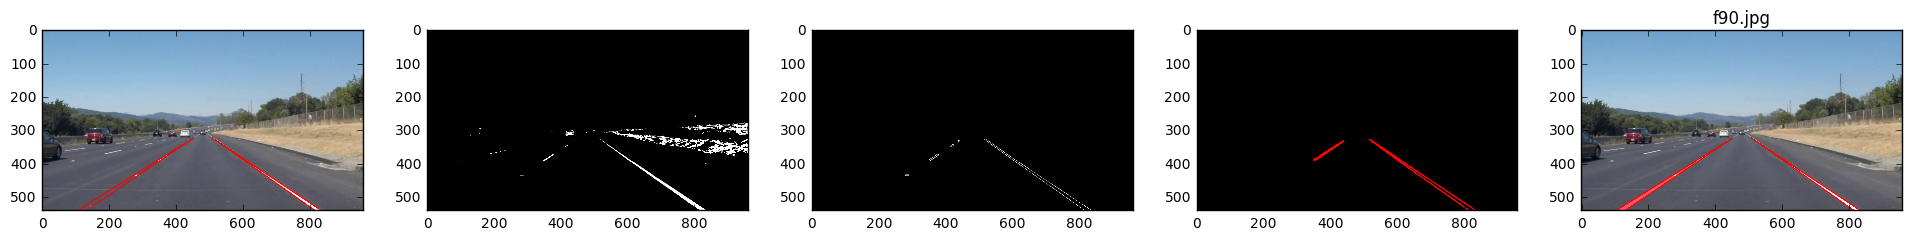

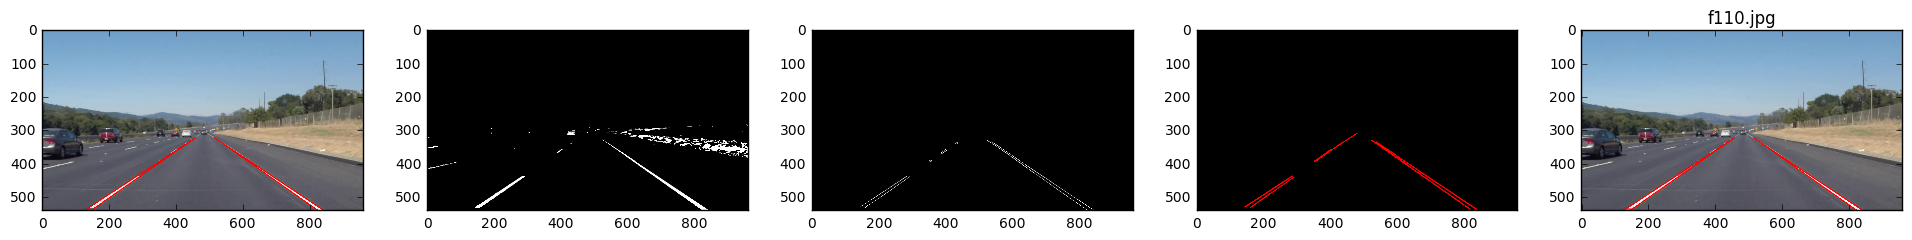

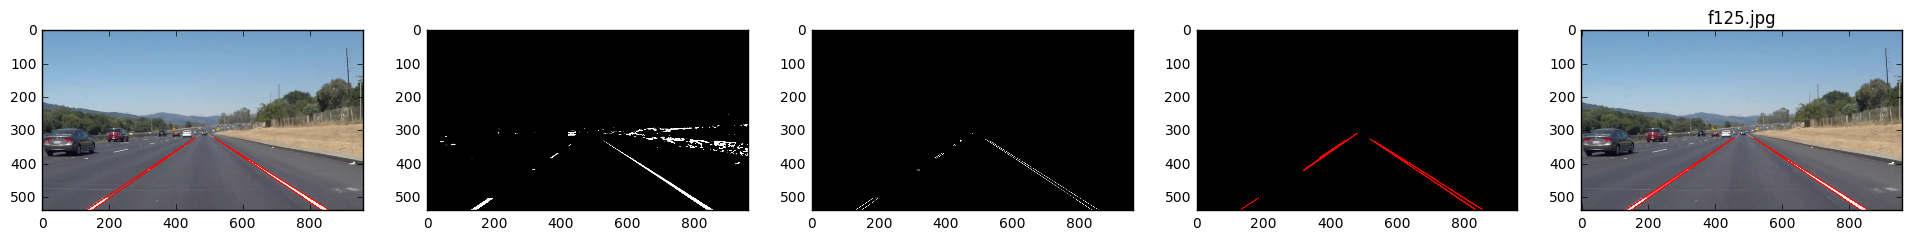

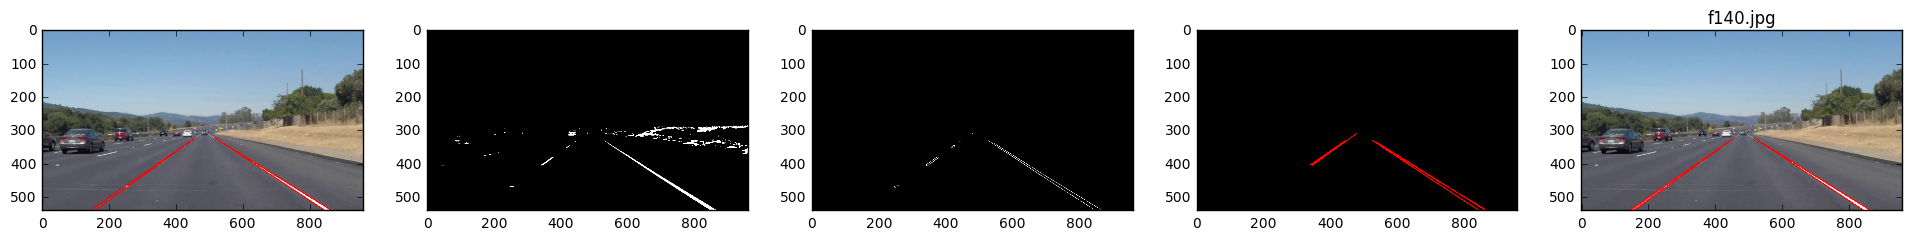

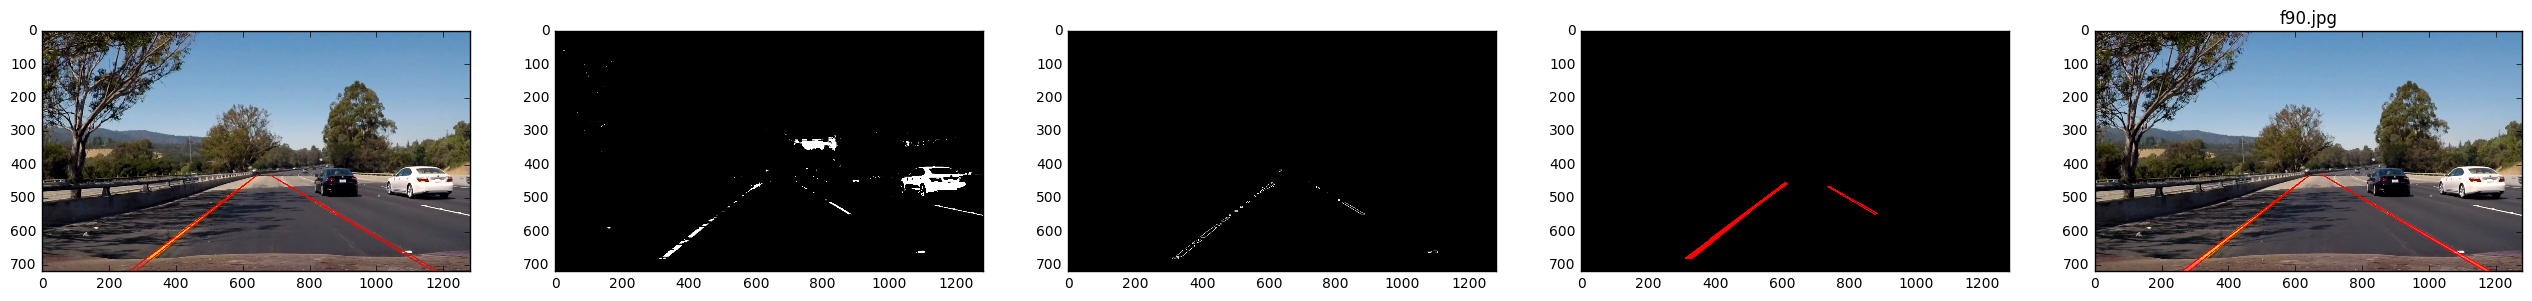

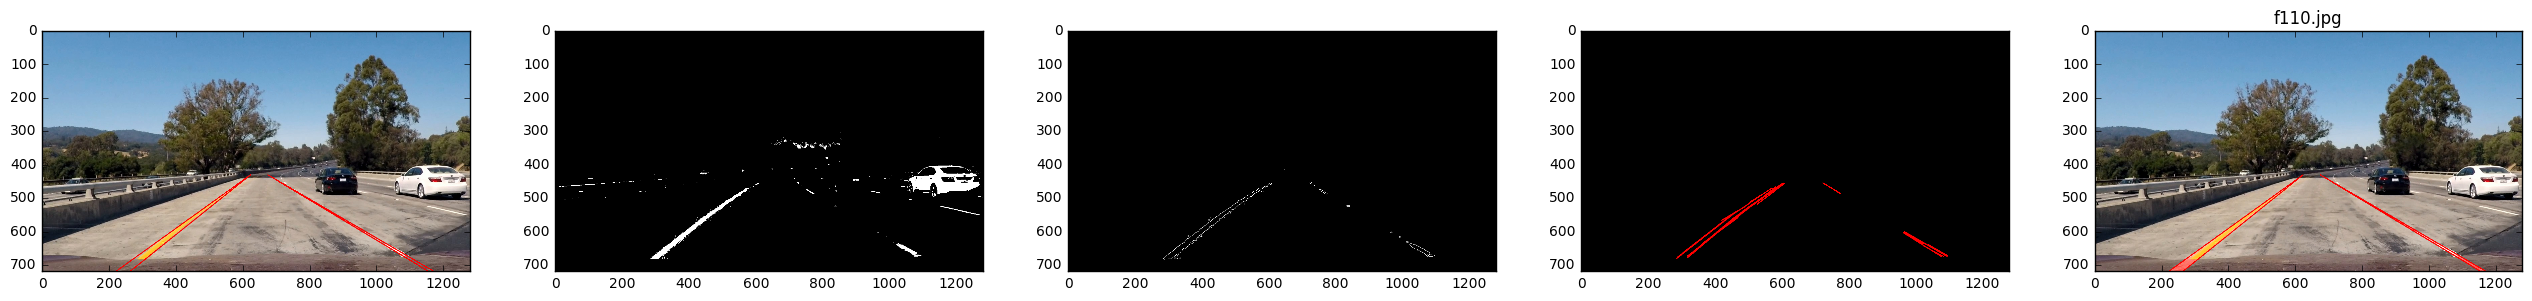

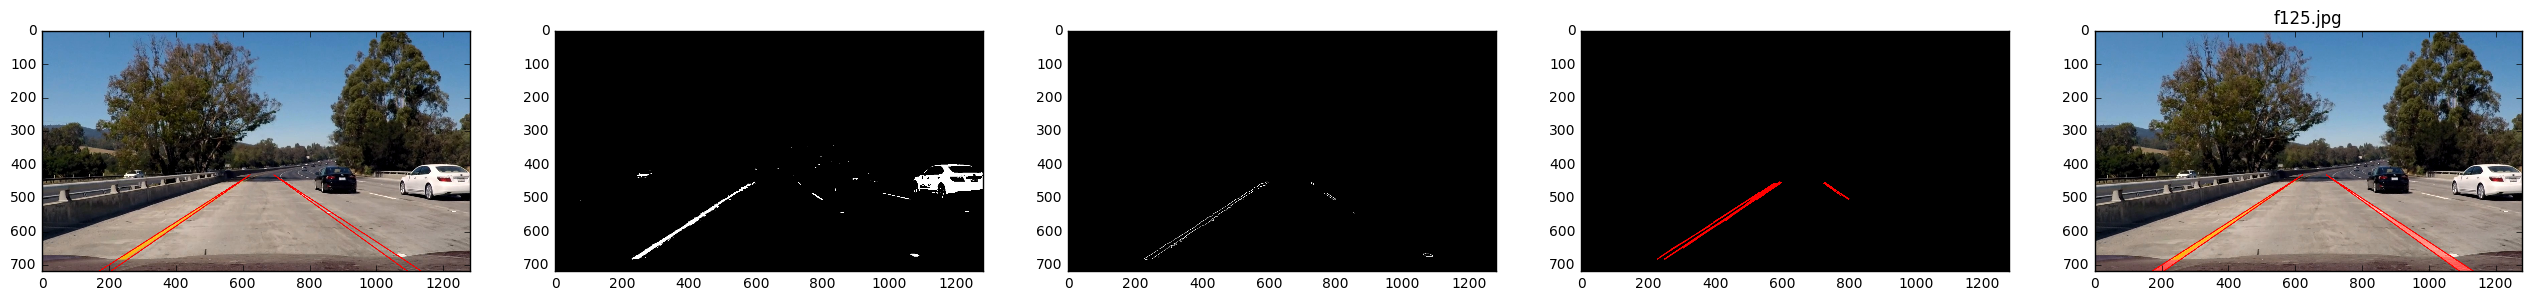

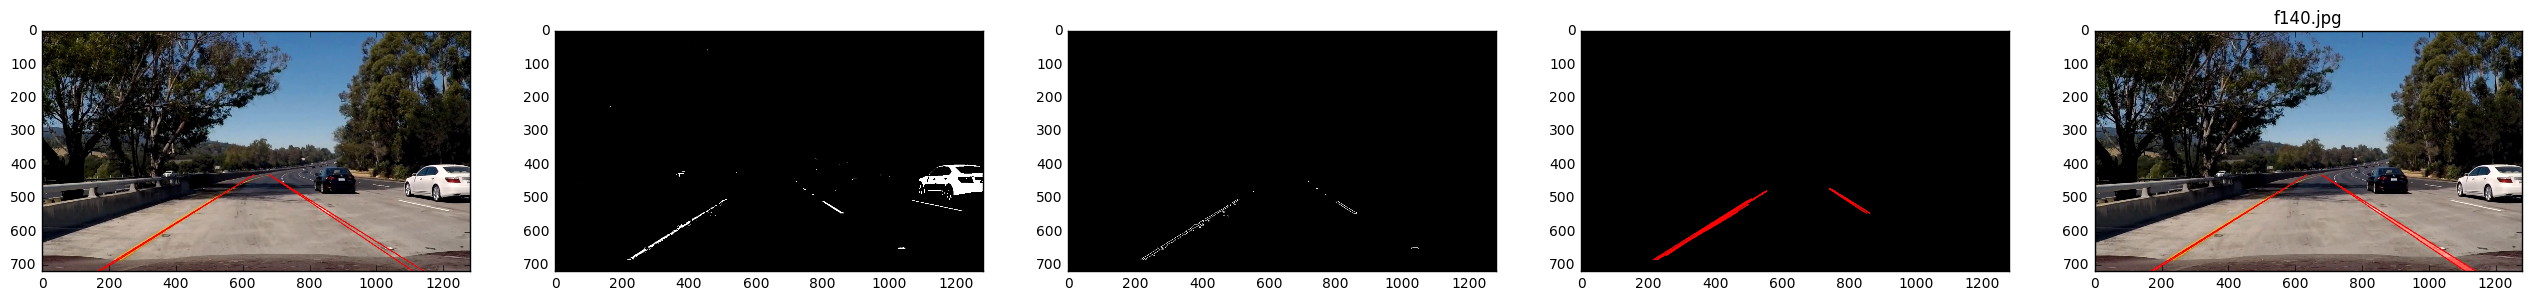

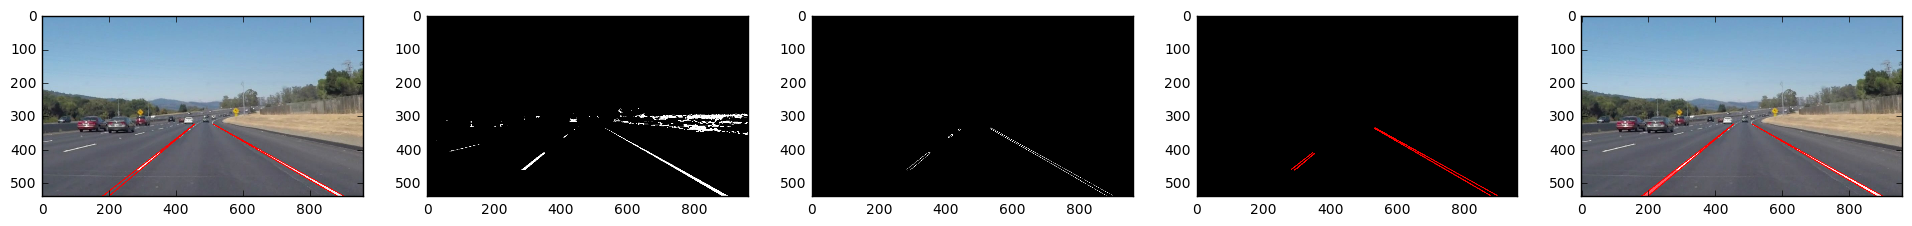

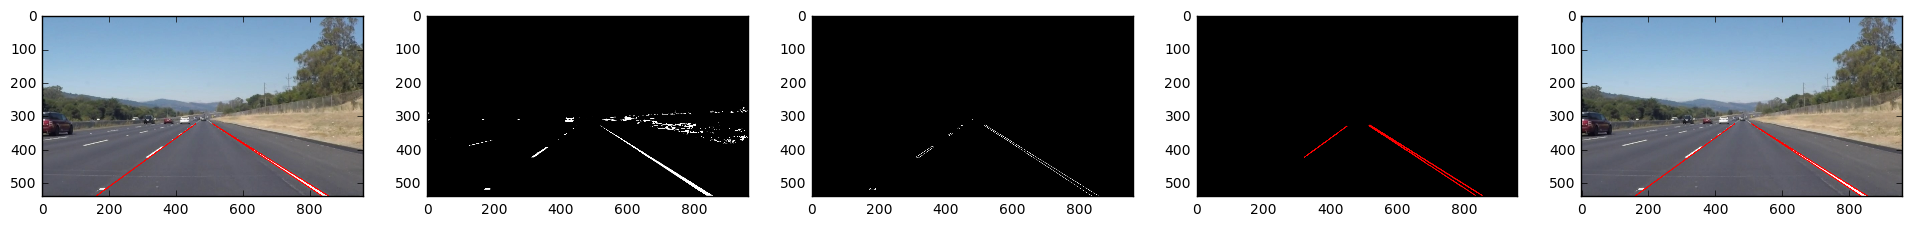

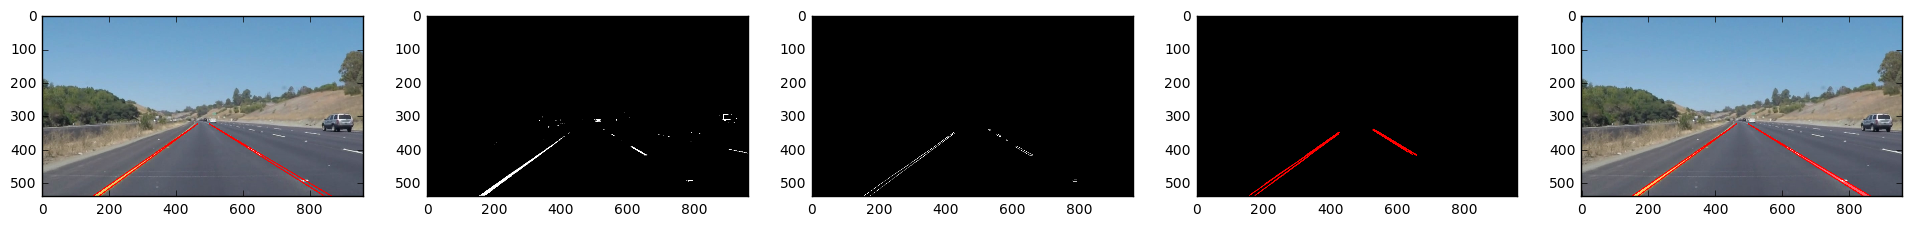

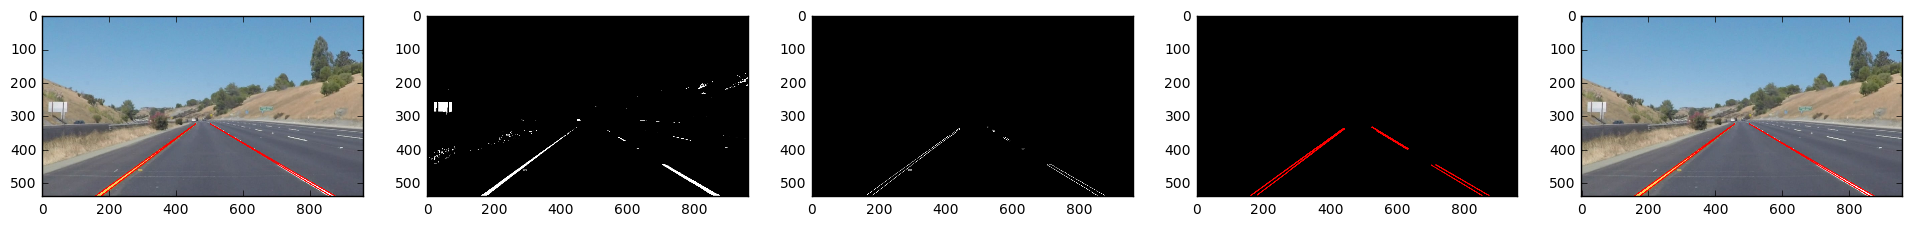

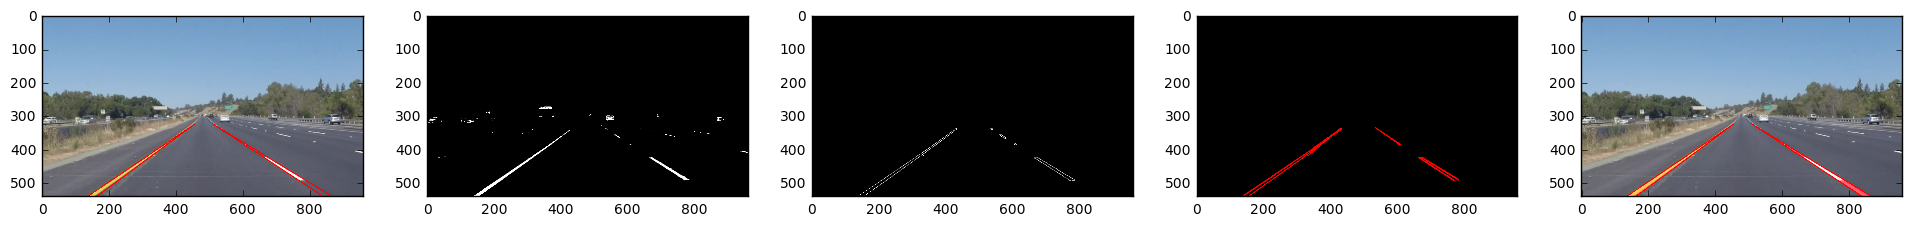

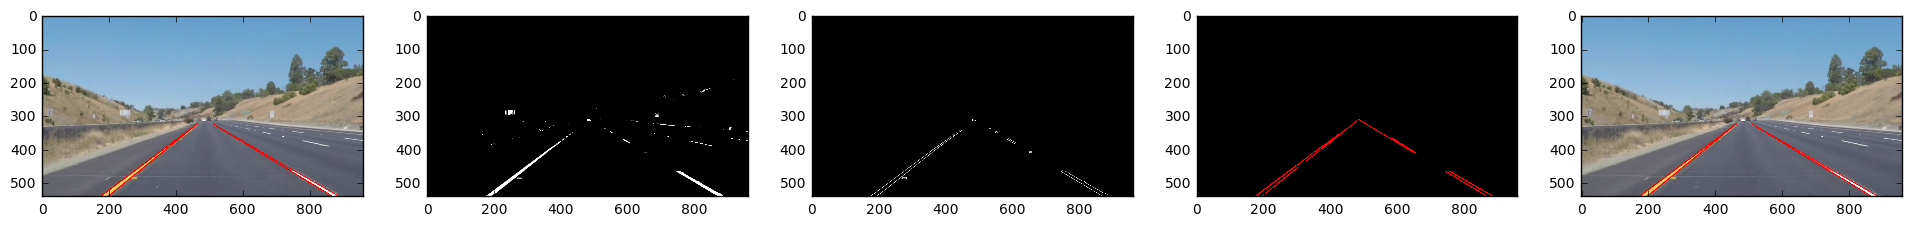

In [18]:
#note this requires that you first extract the frames from the challenge and solid_white videos
frames =['f90.jpg','f110.jpg','f125.jpg','f140.jpg']
'''
for f in frames:
    FRAME_MEMORY=[]
    LINE_MEMORY=[]
    image = mpimg.imread('solid_white/%s'%f)
    results = process_img(image)
    plot_results(results)
    plt.title(f)
    
frames =['f90.jpg','f110.jpg','f125.jpg','f140.jpg']

for f in frames:
    FRAME_MEMORY=[]
    LINE_MEMORY=[]
    image = mpimg.imread('challenge_frames/%s'%f)
    results = process_img(image)
    plot_results(results)
    plt.title(f)
'''

for f in os.listdir("test_images/"):
    FRAME_MEMORY=[]
    LINE_MEMORY=[]
    if not f.endswith('jpg'):
        continue
        
    image = mpimg.imread('test_images/%s'%f)
    results = process_img(image)
    plot_results(results)


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [23]:
#use this to extract frames
i=0
def f(x):
    global i
    im=cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    cv2.imwrite('solid_white/f%d.jpg'%i,im)
    i+=1
    return x


FRAME_MEMORY=[]
LINE_MEMORY=[]
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:11<00:00, 19.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.88 s, sys: 933 ms, total: 7.81 s
Wall time: 13 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">a
</video> 
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
FRAME_MEMORY=[]
LINE_MEMORY=[]
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:39<00:00, 17.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 23.8 s, sys: 2.51 s, total: 26.3 s
Wall time: 41 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Summary
<hr></hr>
<p>The approach I used was to first mask the lanes by color, find edges, clip the frame to a triangular road regions, and finally extract the lines. Lines were filtered and segmented into left/right by their slope. To aggregate the lines into one shape for display, I calculated the intercepts along the lower end and averaged them to get left and right points. Since the lanes become very thin in the distance I calculated a third point from the average line at about half the image height, the output was a bounding triangle. In an attempt to make the algorithm more robust I experimented with including a memory so that the pipeline could remember both where the lanes were previously and what had been seen prior. The motion blur effect of using multiple frames resulted in longer lines detected. The lane result memory made the algorithm more robust when no lines would be detected.</p>
<hr></hr>

### Challenges
<p> The algorithm is fairly fragile. There are many assumptions about lane color which would fail in different lighting conditions. Also I assumed lanes were always straight and traveling more or less in the direction the car is traveling. This would faily along a curve or a lange change. The algorithm is also likely to pick up a curb and think it is a lane.</p>


### Future improvements


* Lane detection in the foreground feels like a different problem than in the distance. I think the foreground could be processed with different parameters than the background and better results might be achieved.
* Different lighting conditions and road colors require different parameters, some method could be created to dynamically set these parameters. For example if the whole image is very bright then the white-lane color range parameters could be set to a stricter value.
* Lane and/or image memory should be used. Under normal and most driving conditions lanes are likely to more or less be in the same place, this information should be used.
* Sanity checks and realistic bounds for what the algorithm returns would help. For example sometimes the algorithm returns a very wide lane line which makes no sense, a simple heuristic like "lane markers in the foreground cannot be larger than 50 pixels" could have helped with that.


<p>I spent way too much time tuning parameters without an objective measure of "lane detection quality". If I were to attempt this again I would generate a few manual ground truth lane markings in photoshop or paint. Had I done that at the start I would have likely saved a lot of time adjusting parameters. Also, I need to get on this python3 thing, been dwelling in 2.7 land. This was fun.</p>

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [27]:
FRAME_MEMORY=[]
LINE_MEMORY=[]
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:24<00:00, 10.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14.1 s, sys: 3.97 s, total: 18.1 s
Wall time: 26.8 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('extra.mp4'))

In [21]:
#save this file
#from zipfile import ZipFile
#with ZipFile('P1.zip', 'w') as myzip:
#    myzip.write('P1.ipynb')